In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

load and check sample data 

In [3]:
n_rois = 68
count_offset = 100
data_path = 'sample_data/abcd_data.npy'
brain_networks, traits, translations, rotations, avg_trans, avg_rotat = preprocess_neural_data(data_path)
n_subs = brain_networks.shape[0]
print(brain_networks.shape)
print(traits.shape)
print(translations.shape)
print(avg_trans.shape)

(8646, 4624)
(8646, 12)
(8646, 6)
(8646, 1)


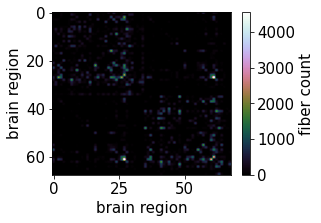

In [4]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect='auto', cmap='cubehelix')
plt.xlabel('brain region')
plt.ylabel('brain region')
plt.colorbar(label='fiber count')
plt.show()

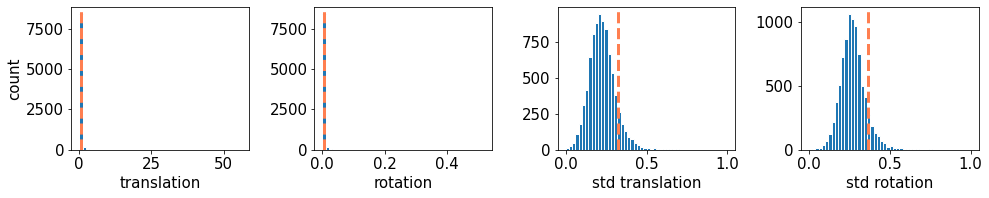

In [5]:
# check motion and rescale motion
# original scale is not ideal so use log transformation and then standardize

std_trans = min_max_standardize(np.log(avg_trans))
std_rotat = min_max_standardize(np.log(avg_rotat))
motion = np.concatenate([std_trans, std_rotat], axis=-1)

fig, axes = plt.subplots(1,4,figsize=(14,3))
axes[0].hist(avg_trans, 50, edgecolor='white')
axes[0].axvline(x=np.quantile(avg_trans, .9), color='coral', ls='dashed', lw=3)
axes[0].set_xlabel('translation')
axes[0].set_ylabel('count')
axes[1].hist(avg_rotat, 50, edgecolor='white')
axes[1].axvline(x=np.quantile(avg_rotat, .9), color='coral', ls='dashed', lw=3)
axes[1].set_xlabel('rotation')
axes[2].hist(std_trans, 50, edgecolor='white')
axes[2].axvline(x=np.quantile(std_trans, .9), color='coral', ls='dashed', lw=3)
axes[2].set_xlabel('std translation')
axes[3].hist(std_rotat, 50, edgecolor='white')
axes[3].axvline(x=np.quantile(std_rotat, .9), color='coral', ls='dashed', lw=3)
axes[3].set_xlabel('std rotation')
plt.tight_layout()
plt.show()

In [6]:
# mark subjects with big motion for later analysis

sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_trans_ids = sub_ids[std_trans > np.quantile(std_trans, .9)]
big_rotat_ids = sub_ids[std_rotat > np.quantile(std_rotat, .9)]
big_motion_ids = np.union1d(big_trans_ids, big_rotat_ids)
big_motion_mask = np.zeros_like(sub_ids)
big_motion_mask[np.isin(sub_ids, big_motion_ids)] = True
print('num of big motion subjects: {}.'.format(len(big_motion_ids)))

small_trans_ids = sub_ids[std_trans < np.quantile(std_trans, .1)]
small_rotat_ids = sub_ids[std_rotat < np.quantile(std_rotat, .1)]
small_motion_ids = np.union1d(small_trans_ids, small_rotat_ids)
small_motion_mask = np.zeros_like(sub_ids)
small_motion_mask[np.isin(sub_ids, small_motion_ids)] = True
print('num of small motion subjects: {}.'.format(len(small_motion_ids)))

num of big motion subjects: 1058.
num of small motion subjects: 1341.


model fitting

In [7]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0.1,
    beta = 1., add_reg = True, y_dim = 1, 
    batch_size=64, n_epochs=200, lr=5e-6, device=DEVICE)

In [8]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits[:,4]).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

7781 865


In [9]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

5 torch.Size([68, 68])


vae

In [10]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr) 

In [11]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 10194.642 nll: 676.258 kl: 133.108 rmse: 12.107
epoch: 0 test loss: 6282.638 nll: -1712.034 kl: 402.744 rmse: 11.050
epoch: 5 train loss: 3881.972 nll: -2326.021 kl: 2522.809 rmse: 7.591
epoch: 5 test loss: 3719.663 nll: -2359.751 kl: 2509.256 rmse: 7.574
epoch: 10 train loss: 3657.614 nll: -2352.473 kl: 2537.817 rmse: 7.368
epoch: 10 test loss: 3504.767 nll: -2381.343 kl: 2535.709 rmse: 7.337
epoch: 15 train loss: 3452.250 nll: -2359.042 kl: 2547.476 rmse: 7.143
epoch: 15 test loss: 3308.293 nll: -2387.098 kl: 2567.893 rmse: 7.088
epoch: 20 train loss: 3257.753 nll: -2361.972 kl: 2554.362 rmse: 6.922
epoch: 20 test loss: 3121.053 nll: -2389.834 kl: 2590.373 rmse: 6.849
epoch: 25 train loss: 3075.004 nll: -2363.998 kl: 2559.770 rmse: 6.707
epoch: 25 test loss: 2946.418 nll: -2391.671 kl: 2614.263 rmse: 6.614
epoch: 30 train loss: 2903.521 nll: -2366.400 kl: 2561.202 rmse: 6.505
epoch: 30 test loss: 2782.985 nll: -2394.013 kl: 2629.012 rmse: 6.396
epoch: 35 train lo

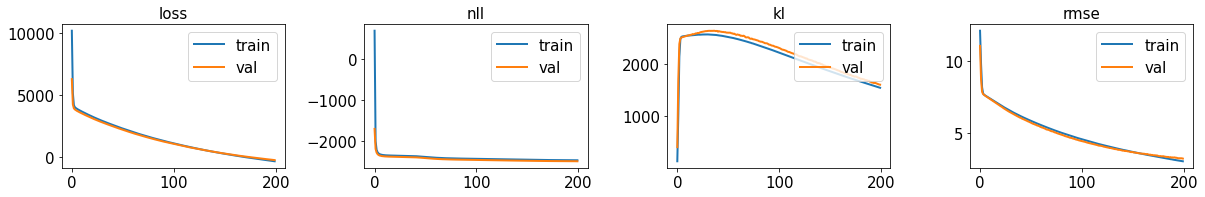

In [12]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [58]:
# torch.save(model.state_dict(), './pretrained/abcd_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/abcd_vae_pretrained.mod'))

In [14]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()
x_recon = model.decode(z_sample).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

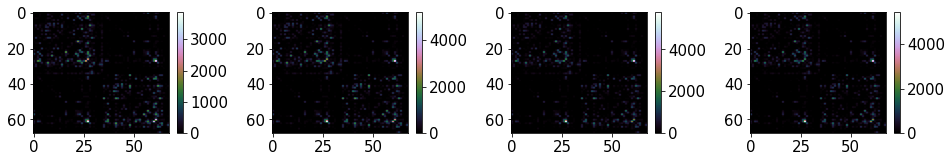

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [16]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_recon = x_recon[big_motion_ids]
small_motion_recon = x_recon[small_motion_ids]
diff_motion_recon= big_motion_recon.mean(0) - small_motion_recon.mean(0)

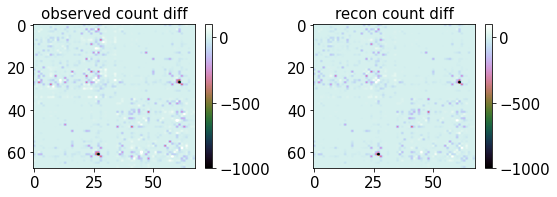

In [17]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_recon.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('recon count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

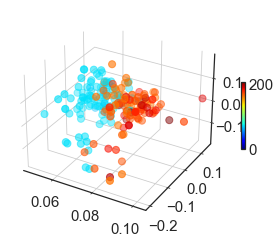

In [18]:
# viz of trait prediction

x_recon, y_pred, _, _ = model(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
y_pred = y_pred.detach().cpu().numpy()
y_obs = traits[:,4]

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(z_mean_sub.transpose())
pca_results = pca.components_.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

inv-vae

In [39]:
# model config

config = Namespace(n_nodes=68, latent_dim=68, hidden_dim=1024, nuisance_dim=2,
    n_enc_layers=1, n_dec_layers=5, n_neighbors=32, drop_out=0., 
    beta = 1., gamma = .01, add_reg = True, y_dim = 1,
    batch_size=64, n_epochs=200, lr=5e-6, device=DEVICE)

In [40]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr) 

In [41]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 9569.802 nll: 442.249 kl: 154.374 inv_loss: 0.275 rmse: 12.224
epoch: 0 test loss 7748.490 nll: -1914.995 kl: 523.108 inv_loss: 0.735 rmse: 11.177
epoch: 5 train loss: 679.184 nll: -2331.774 kl: 19614.592 inv_loss: 1.585 rmse: 3.295
epoch: 5 test loss 666.940 nll: -2364.391 kl: 19960.436 inv_loss: 1.642 rmse: 3.312
epoch: 10 train loss: 658.637 nll: -2352.652 kl: 19493.862 inv_loss: 1.237 rmse: 3.248
epoch: 10 test loss 645.281 nll: -2381.233 kl: 19778.237 inv_loss: 1.275 rmse: 3.260
epoch: 15 train loss: 630.667 nll: -2357.407 kl: 19692.920 inv_loss: 0.988 rmse: 3.181
epoch: 15 test loss 616.231 nll: -2385.267 kl: 19958.766 inv_loss: 0.995 rmse: 3.188
epoch: 20 train loss: 596.644 nll: -2359.050 kl: 19846.719 inv_loss: 0.776 rmse: 3.098
epoch: 20 test loss 581.614 nll: -2386.773 kl: 20219.368 inv_loss: 0.763 rmse: 3.100
epoch: 25 train loss: 558.923 nll: -2359.856 kl: 19906.543 inv_loss: 0.625 rmse: 3.002
epoch: 25 test loss 544.332 nll: -2387.145 kl: 20323.946 in

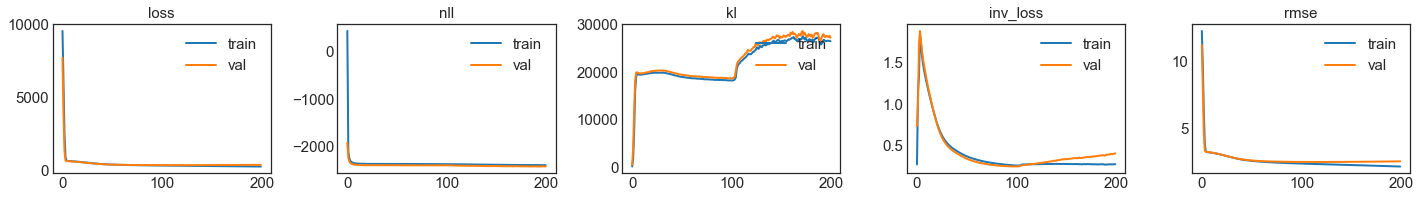

In [42]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [56]:
# torch.save(inv_model.state_dict(), './pretrained/abcd_inv_vae_pretrained.mod')
# inv_model.load_state_dict(torch.load('./pretrained/abcd_inv_vae_pretrained.mod'))

In [44]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised = inv_model.decode(z_sample, 
                      torch.zeros_like(tensor_motion).to(config.device) 
                      ).detach().cpu().numpy().reshape(-1, config.n_nodes, config.n_nodes)

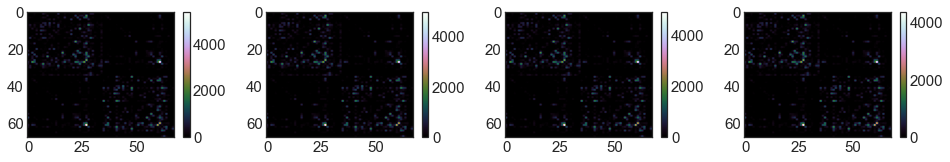

In [45]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='cubehelix')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [46]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_denoised = x_denoised[big_motion_ids]
small_motion_denoised = x_denoised[small_motion_ids]
diff_motion_denoised = big_motion_denoised.mean(0) - small_motion_denoised.mean(0)

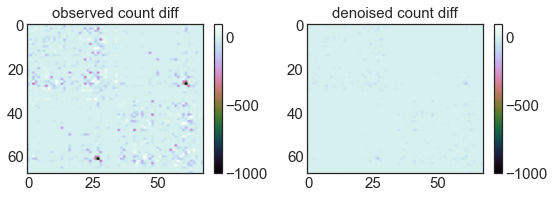

In [47]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_denoised.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('denoised count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

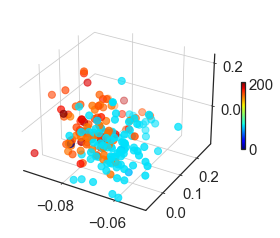

In [48]:
# viz of trait prediction

x_recon, y_pred, _, _ = inv_model(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
                            tensor_motion.to(config.device))
y_pred = y_pred.detach().cpu().numpy()
y_obs = traits[:,4]

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy()
pca = PCA(n_components=3)
pca.fit(z_mean_sub.transpose())
pca_results = pca.components_.transpose()

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'jet', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))